<a href="https://colab.research.google.com/github/gashawmg/Buchwald-9-vs-120-features/blob/master/10_Descriptors_for_%20Buchwald_Yield_Prediction%20Using%20plate%201%20and%202%20as%20training%20sets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The top 20 conditions of XGBoost obtained using 120 descriptors 
Predicting reaction performance in C–N cross-coupling using machine learning
Experimental data obtained from Ahneman et al publication in Science DOI: 10.1126/science.aar5169
                    

                                                 Gashaw M. Goshu, September 26, 2020

In [42]:
# Import relevant libraries
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sn
from sklearn.model_selection import cross_validate,train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#import utils
%matplotlib inline

In [43]:
# open a file containing descriptors and yield
data = pd.read_csv("Descriptor_and_yield_table.csv")


In [44]:
data

,Unnamed: 0,additive_*C3_NMR_shift,additive_*C3_electrostatic_charge,additive_*C4_NMR_shift,additive_*C4_electrostatic_charge,additive_*C5_NMR_shift,additive_*C5_electrostatic_charge,additive_*N1_electrostatic_charge,additive_*O1_electrostatic_charge,additive_E_HOMO,...,ligand_V6_frequency,ligand_V6_intensity,ligand_V7_frequency,ligand_V7_intensity,ligand_V8_frequency,ligand_V8_intensity,ligand_V9_frequency,ligand_V9_intensity,ligand_dipole_moment,yield
0,1,143.12,0.223,93.06,-0.447,162.34,0.292,-0.334,-0.057,-0.2317,...,1640.307,4.414,3026.561,16.577,3043.097,18.145,3064.344,38.210,1.212924,10.657812
1,2,143.12,0.223,93.06,-0.447,162.34,0.292,-0.334,-0.057,-0.2317,...,1640.307,4.414,3026.561,16.577,3043.097,18.145,3064.344,38.210,1.212924,14.747896
2,3,143.12,0.223,93.06,-0.447,162.34,0.292,-0.334,-0.057,-0.2317,...,1640.307,4.414,3026.561,16.577,3043.097,18.145,3064.344,38.210,1.212924,18.278686
3,4,143.12,0.223,93.06,-0.447,162.34,0.292,-0.334,-0.057,-0.2317,...,1640.307,4.414,3026.561,16.577,3043.097,18.145,3064.344,38.210,1.212924,2.475058
4,5,143.12,0.223,93.06,-0.447,162.34,0.292,-0.334,-0.057,-0.2317,...,1640.307,4.414,3026.561,16.577,3043.097,18.145,3064.344,38.210,1.212924,6.119058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,3956,152.98,0.429,98.09,-0.589,159.31,0.387,-0.350,-0.068,-0.2337,...,1631.618,37.445,3025.675,16.220,1054.500,1.432,3041.406,35.621,3.735286,57.426670
3956,3957,152.98,0.429,98.09,-0.589,159.31,0.387,-0.350,-0.068,-0.2337,...,1631.618,37.445,3025.675,16.220,1054.500,1.432,3041.406,35.621,3.735286,86.233157
3957,3958,152.98,0.429,98.09,-0.589,159.31,0.387,-0.350,-0.068,-0.2337,...,1631.618,37.445,3025.675,16.220,1054.500,1.432,3041.406,35.621,3.735286,1.440081
3958,3959,152.98,0.429,98.09,-0.589,159.31,0.387,-0.350,-0.068,-0.2337,...,1631.618,37.445,3025.675,16.220,1054.500,1.432,3041.406,35.621,3.735286,43.538365


In [45]:
features =["additive_*C3_NMR_shift",
            "aryl_halide_*C3_NMR_shift","aryl_halide_*H2_electrostatic_charge",
            "base_*N1_electrostatic_charge","ligand_*C11_NMR_shift",
            "additive_*C4_electrostatic_charge","base_E_HOMO","aryl_halide_V2_frequency",
            "aryl_halide_E_LUMO","additive_E_LUMO"
            ]
X_data = data[features] # the 10 descriptors gave better prediction than the published paper.
y_data = data['yield'] # Yield of the 3560 rows is stored in the y_data variable

In [46]:
data.isna().sum()

Unnamed: 0                           0
additive_*C3_NMR_shift               0
additive_*C3_electrostatic_charge    0
additive_*C4_NMR_shift               0
additive_*C4_electrostatic_charge    0
                                    ..
ligand_V8_intensity                  0
ligand_V9_frequency                  0
ligand_V9_intensity                  0
ligand_dipole_moment                 0
yield                                0
Length: 122, dtype: int64

In [47]:
X_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   additive_*C3_NMR_shift                3960 non-null   float64
 1   aryl_halide_*C3_NMR_shift             3960 non-null   float64
 2   aryl_halide_*H2_electrostatic_charge  3960 non-null   float64
 3   base_*N1_electrostatic_charge         3960 non-null   float64
 4   ligand_*C11_NMR_shift                 3960 non-null   float64
 5   additive_*C4_electrostatic_charge     3960 non-null   float64
 6   base_E_HOMO                           3960 non-null   float64
 7   aryl_halide_V2_frequency              3960 non-null   float64
 8   aryl_halide_E_LUMO                    3960 non-null   float64
 9   additive_E_LUMO                       3960 non-null   float64
dtypes: float64(10)
memory usage: 309.5 KB


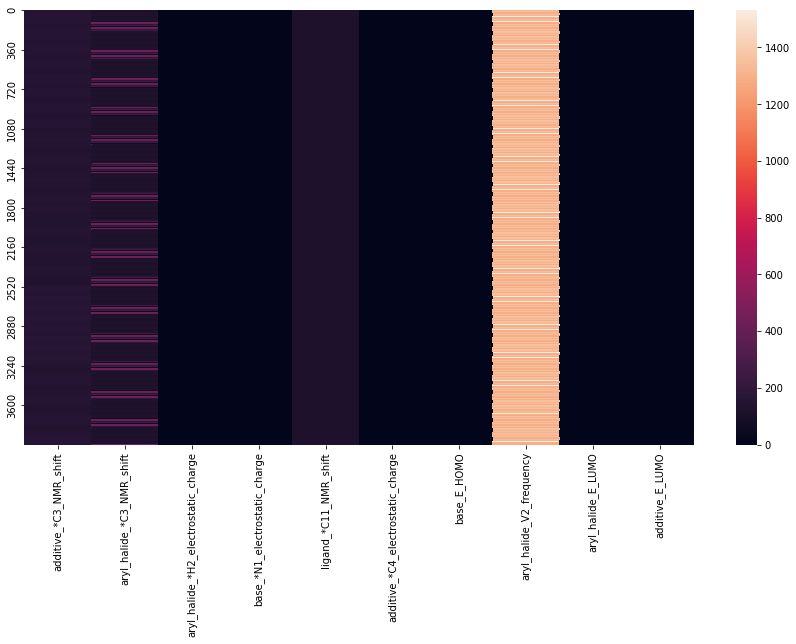

In [48]:
# Set the width and height of the figure
plt.figure(figsize=(15,8))
# Generate heatmap for the 10 columns or descriptors
sn.heatmap(data=X_data,yticklabels=360)

In [49]:
# predicting the effects of additives on yield in plate 3 using plate 1 and plate 2 as training sets  
# Predict plate 3 (index: 2520:3960))  using plate 1 and plate 2 ( index 0:2520)
X_train, X_test, y_train, y_test = X_data[:2520], X_data[2520:], y_data[:2520], y_data[2520:]
rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [50]:
# Data preprocessing or normalization
# scale train set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# scale test set
X_test = scaler.transform(X_test)

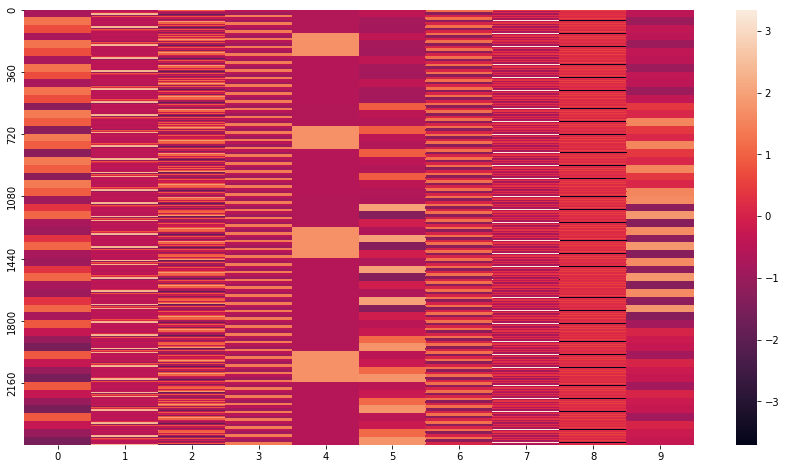

In [51]:
plt.figure(figsize=(15,8))
sn.heatmap(data=X_train,yticklabels=360)

In [52]:
X_train.shape

(2520, 10)

In [53]:
X_data

,additive_*C3_NMR_shift,aryl_halide_*C3_NMR_shift,aryl_halide_*H2_electrostatic_charge,base_*N1_electrostatic_charge,ligand_*C11_NMR_shift,additive_*C4_electrostatic_charge,base_E_HOMO,aryl_halide_V2_frequency,aryl_halide_E_LUMO,additive_E_LUMO
0,143.12,120.97,0.143,-0.755,114.03,-0.447,-0.1703,1351.720,-0.0396,-0.0487
1,143.12,120.95,0.100,-0.755,114.03,-0.447,-0.1703,1349.391,-0.0413,-0.0487
2,143.12,181.37,0.083,-0.755,114.03,-0.447,-0.1703,1346.735,-0.0429,-0.0487
3,143.12,112.08,0.137,-0.755,114.03,-0.447,-0.1703,1351.340,-0.0118,-0.0487
4,143.12,112.39,0.099,-0.755,114.03,-0.447,-0.1703,1532.172,-0.3500,-0.0487
...,...,...,...,...,...,...,...,...,...,...
3955,152.98,129.62,0.138,-0.611,114.09,-0.589,-0.1913,1311.840,-0.0391,-0.0696
3956,152.98,256.46,0.137,-0.611,114.09,-0.589,-0.1913,1305.598,-0.0383,-0.0696
3957,152.98,117.10,0.102,-0.611,114.09,-0.589,-0.1913,1298.019,-0.0380,-0.0696
3958,152.98,117.61,0.065,-0.611,114.09,-0.589,-0.1913,1295.516,-0.0390,-0.0696


In [54]:
# change yield to numpy array
y_train = np.array(y_train)
y_test = np.array(y_test)

In [55]:
# cross validation score
scores= cross_validate(rf,X_train,y_train,scoring=('r2','neg_mean_squared_error'),cv=3)

In [56]:
scores.keys()

dict_keys(['fit_time', 'score_time', 'test_r2', 'test_neg_mean_squared_error'])

In [57]:
scores['test_r2']

array([0.69323641, 0.81058174, 0.1828662 ])

In [58]:
np.sqrt(-scores['test_neg_mean_squared_error'])

array([16.03387949, 12.35992135, 21.30952728])

In [59]:
# Model Training and prediction
rf.fit(X_train,y_train) # training using 70% of the data
predicted_yield =rf.predict(X_test) # predicting yield for 30% of the data

In [60]:
# Model accuracy using root mean square error 
rmse = np.sqrt(mean_squared_error(y_test, predicted_yield )) 
print('rmse:', rmse)

rmse: 11.255806705631763


In [61]:
# R^2 (coefficient of determination) regression score function: 
R2 =r2_score(y_test, predicted_yield ) 
print('R^2:', R2)

R^2: 0.8099551006176957


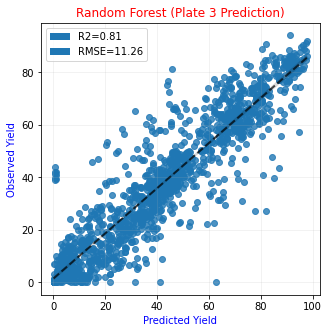

In [62]:
# from the publication RMSE = 11% and R2 = 0.83
plt.figure(figsize=(5,5))
sn.regplot(x=predicted_yield , y=y_test,line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.7})
plt.xlabel('Predicted Yield', color='blue')
plt.ylabel('Observed Yield', color ='blue')
plt.title("Random Forest (Plate 3 Prediction)", color='red')
plt.grid(alpha=0.2)
R2 = mpatches.Patch(label="R2={:04.2f}".format(R2))
rmse = mpatches.Patch(label="RMSE={:04.2f}".format(rmse))
plt.legend(handles=[R2, rmse])

In [63]:
# XGBoost the most widely used ML model in kaggle competition
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=100, random_state=42)

In [64]:
# Model Training and prediction
xgb.fit(X_train,y_train) # training using 70% of the data
predicted_yield2 = xgb.predict(X_test) # predicting yield for 30% of the data

[21:44:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [65]:
# Model accuracy using root mean square error 
rmse2 = np.sqrt(mean_squared_error(y_test, predicted_yield2))  
print('rmse:', rmse2)

rmse: 13.17001180779102


In [66]:
# R^2 (coefficient of determination) regression score function: 
R_2 = r2_score(y_test, predicted_yield2)
print('R^2:', R_2)

R^2: 0.7398191705321411


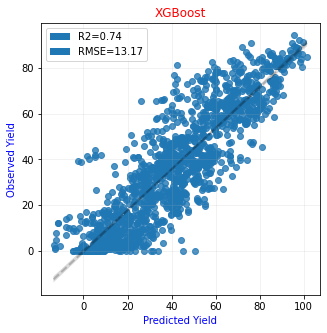

In [67]:
fig = plt.figure(figsize=(5,5))
sn.regplot(x=predicted_yield2, y=y_test,line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.2})
plt.xlabel('Predicted Yield', color='blue')
plt.ylabel('Observed Yield', color ='blue')
plt.title("XGBoost", color='red')
plt.grid(alpha=0.2)
R_2 = mpatches.Patch(label="R2={:04.2f}".format(R_2))
rmse2 = mpatches.Patch(label="RMSE={:04.2f}".format(rmse2))
plt.legend(handles=[R_2, rmse2])

In [68]:
# # Neural network
# sr = MLPRegressor(hidden_layer_sizes=(1200),
#                        activation='logistic',
#                        solver='sgd',
#                        max_iter=10000,
#                        random_state=42)
# sr.fit(X_train,y_train)
# predicted_yield3 = sr.predict(X_test)

In [69]:
# # R^2 (coefficient of determination) regression score function: 
# R_3 = r2_score(y_test, predicted_yield3)
# print('R^2:', R_3)

In [70]:
model = keras.Sequential([
    layers.Input(shape=(10,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

In [71]:
model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

In [72]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 32)                352       
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                1056      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,553
Trainable params: 3,553
Non-traina

In [73]:
history= model.fit(X_train,y_train, epochs=50,validation_split=0.2)

Epoch 1/50
63/63 [==============================] - 1s 4ms/step - loss: 29.8746 - val_loss: 19.3308
Epoch 2/50
63/63 [==============================] - 0s 2ms/step - loss: 20.5434 - val_loss: 16.7911
Epoch 3/50
63/63 [==============================] - 0s 2ms/step - loss: 18.2152 - val_loss: 16.1735
Epoch 4/50
63/63 [==============================] - 0s 2ms/step - loss: 17.4072 - val_loss: 16.0116
Epoch 5/50
63/63 [==============================] - 0s 3ms/step - loss: 16.8006 - val_loss: 15.7066
Epoch 6/50
63/63 [==============================] - 0s 2ms/step - loss: 16.1882 - val_loss: 15.0356
Epoch 7/50
63/63 [==============================] - 0s 2ms/step - loss: 15.6861 - val_loss: 14.9486
Epoch 8/50
63/63 [==============================] - 0s 2ms/step - loss: 14.9643 - val_loss: 14.3390
Epoch 9/50
63/63 [==============================] - 0s 2ms/step - loss: 14.4475 - val_loss: 14.6780
Epoch 10/50
63/63 [==============================] - 0s 2ms/step - loss: 14.3129 - val_loss: 14.3409

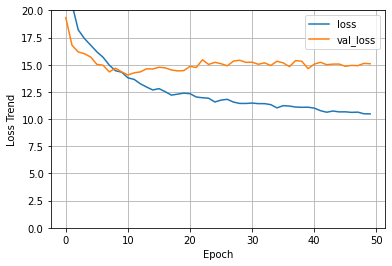

In [74]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 20])
plt.xlabel('Epoch')
plt.ylabel('Loss Trend')
plt.legend()
plt.grid(True)

In [75]:
# %%time
# history = model.fit(
#     X_train, y_train,
#     validation_split=0.2,
#     verbose=0, epochs=100)

In [76]:
# plot_loss(history)

In [77]:
predicted_yield4 = model.predict(X_test)
y_test

array([24.10905766, 32.87780619, 43.39942952, ...,  1.44008073,
       43.53836522, 69.79590237])

In [78]:
predicted_yield4

array([[50.010754],
       [72.16791 ],
       [85.902275],
       ...,
       [28.56197 ],
       [65.28362 ],
       [87.172386]], dtype=float32)

In [79]:
# predicted_yield4
# for i,j in enumerate (predicted_yield4):
#     print(f'Predicted yield= {j} and Actual yield ={y_test[i]}' )
    

In [80]:
# R^2 (coefficient of determination) regression score function: 
R_4 = r2_score(y_test, predicted_yield4)
print('R^2:', R_4)

R^2: -0.17843031162805834


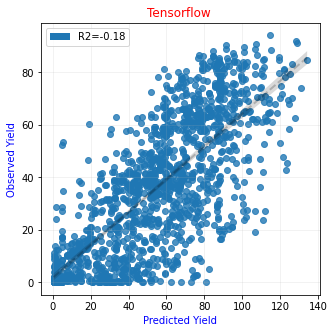

In [81]:
fig = plt.figure(figsize=(5,5))
sn.regplot(x=predicted_yield4, y=y_test,line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.2})
plt.xlabel('Predicted Yield', color='blue')
plt.ylabel('Observed Yield', color ='blue')
plt.title("Tensorflow ", color='red')
plt.grid(alpha=0.2)
R_4 = mpatches.Patch(label="R2={:04.2f}".format(R_4))
# rmse2 = mpatches.Patch(label="RMSE={:04.2f}".format(rmse2))
plt.legend(handles=[R_4])